# physionet2012 데이터 전처리
- 데이터 가져오기
- scaler 가져오기
- X, y 분리하기
- scaler 적용하기
- model에 입력가능한 3차원 형태 데이터 만들기
- (batch_size, maxlen, feature_dim)

In [1]:
# 전처리된 데이터 가져오기

import numpy as np
import pandas as pd

path = '/Users/jsha/gjai/final_project/black_swan_physionet/'
file = 'train_done_preprocessing.csv'
file2 = 'valid_done_preprocessing.csv'
file3 = 'test_done_preprocessing.csv'

train_df = pd.read_csv(path+file)
valid_df = pd.read_csv(path+file2)
test_df = pd.read_csv(path+file3)

maxlen = len(train_df[train_df['pid'] == train_df['pid'][0]])

In [2]:
# labels 컬럼 인덱스 찾기
inx = test_df.columns.get_indexer(['labels'])
print(inx)

# X, y 분리
y_train = train_df['labels']
X_train_nonorm = train_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_train.shape)
print(X_train_nonorm.shape)

y_valid = valid_df['labels']
X_valid_nonorm = valid_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_valid.shape)
print(X_valid_nonorm.shape)

y_test = test_df['labels']
X_test_nonorm = test_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_test.shape)
print(X_test_nonorm.shape)

[41]
(226800,)
(226800, 40)
(25200,)
(25200, 40)
(28000,)
(28000, 40)


In [3]:
# scaler를 이용한 정규화

import pickle

mms = 'mms.pickle'
with open(path+mms, 'rb') as handler:
    load_mms = pickle.load(handler)
    
X_train = load_mms.transform(X_train_nonorm)
X_valid = load_mms.transform(X_valid_nonorm)
X_test = load_mms.transform(X_test_nonorm)

print(X_train.shape)
print(y_train.shape)
X_train_3d = X_train.reshape((-1, maxlen, X_train.shape[-1]))
print(X_train_3d.shape)
y_train_3d = y_train[::maxlen]
print(y_train_3d.shape)

X_valid_3d = X_valid.reshape((-1, maxlen, X_valid.shape[-1]))
print(X_valid_3d.shape)
y_valid_3d = y_valid[::maxlen]
print(y_valid_3d.shape)

X_test_3d = X_test.reshape((-1, maxlen, X_test.shape[-1]))
print(X_test_3d.shape)
y_test_3d = y_test[::maxlen]
print(y_test_3d.shape)

(226800, 40)
(226800,)
(3240, 70, 40)
(3240,)
(360, 70, 40)
(360,)
(400, 70, 40)
(400,)


# Model 설계 

## LSTM

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, Conv2D

feature_dim = X_train.shape[-1]

lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='tanh', input_shape=(maxlen, feature_dim), return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64, activation='tanh'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(32, activation='relu'))
# lstm_model.add(Flatten())
lstm_model.add(Dense(8, activation='relu'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

2022-11-22 19:31:45.983155: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 70, 64)            26880     
                                                                 
 dropout (Dropout)           (None, 70, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0

In [6]:
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics='acc')

In [7]:
# 모델 학습하기

from tensorflow.keras.callbacks import EarlyStopping

epochs = 20
batch_size = 40

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

lstm_history = lstm_model.fit(X_train_3d, y_train_3d, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_valid_3d, y_valid_3d))

Epoch 1/20
81/81 [==============================] - 7s 53ms/step - loss: 0.4331 - acc: 0.8611 - val_loss: 0.3897 - val_acc: 0.8639
Epoch 2/20
81/81 [==============================] - 3s 43ms/step - loss: 0.3775 - acc: 0.8688 - val_loss: 0.3390 - val_acc: 0.8639
Epoch 3/20
81/81 [==============================] - 4s 49ms/step - loss: 0.3527 - acc: 0.8673 - val_loss: 0.3199 - val_acc: 0.8639
Epoch 4/20
81/81 [==============================] - 4s 50ms/step - loss: 0.3411 - acc: 0.8691 - val_loss: 0.3310 - val_acc: 0.8639
Epoch 5/20
81/81 [==============================] - 4s 45ms/step - loss: 0.3370 - acc: 0.8682 - val_loss: 0.3380 - val_acc: 0.8639
Epoch 6/20
81/81 [==============================] - 4s 46ms/step - loss: 0.3506 - acc: 0.8685 - val_loss: 0.3239 - val_acc: 0.8639
Epoch 7/20
81/81 [==============================] - 4s 46ms/step - loss: 0.3326 - acc: 0.8707 - val_loss: 0.3276 - val_acc: 0.8667
Epoch 8/20
81/81 [==============================] - 4s 46ms/step - loss: 0.3359 - a

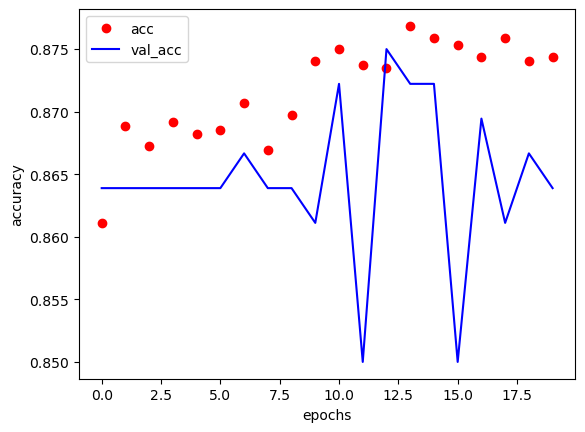

In [8]:
# epoch별 model acc 비교하기 

import matplotlib.pyplot as plt

history = lstm_history.history

loss = history['loss']
acc = history['acc']
val_loss = history['val_loss']
val_acc = history['val_acc']
length = len(val_acc)

plt.plot(range(length), acc, 'ro', label='acc')
plt.plot(range(length), val_acc, 'b-', label='val_acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

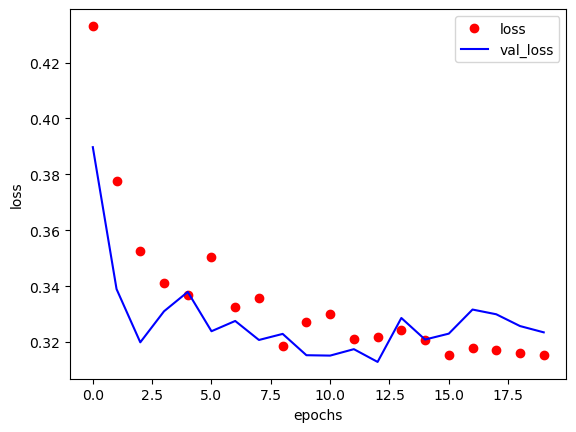

In [9]:
# epoch별 모델 loss 확인하기

plt.plot(range(length), loss, 'ro', label='loss')
plt.plot(range(length), val_loss, 'b-', label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [10]:
# test acc 구하기

test_loss, test_acc = lstm_model.evaluate(X_test_3d, y_test_3d)
print(f'test_acc: {test_acc:.2f}')
print(f'test_loss: {test_loss:.2f}')

13/13 [==============================] - 1s 19ms/step - loss: 0.2983 - acc: 0.8875
test_acc: 0.89
test_loss: 0.30


In [11]:
# auroc 구하기

from sklearn.metrics import roc_auc_score

test_pred = lstm_model.predict(X_test_3d)
auc = roc_auc_score(y_test_3d, test_pred)

print(f'acc_test: {test_acc:.2f}')
print(f'auc_score_test: {auc:.2f}')

13/13 [==============================] - 1s 12ms/step
acc_test: 0.89
auc_score_test: 0.83


## LSTM 모델

- 일단 전반적으로 학습이 되지 않는다.
    - 학습 과정 중 val_acc의 수치 변화가 없다.
    - 학습 과정 중 loss가 강하게 튀는 것을 볼 수 있는데 그 이유는 무엇일까?
- simple_dense_model보다 성능이 좋지 않다.
- 층을 깊게 쌓을수록 학습되지 않는 현상이 심하게 나타난다.
    - 층을 간단하게 하니, loss가 튀는 것을 막을 수 있었다.
    - 하지만, 학습되지 않는 건 여전하다.
- 확실하진 않지만, lstm을 두 개 연속으로 연결할 때 loss가 튀는 현상이 보인다.
- batch_size와 epoch를 조절해 보자.